# Predict the wind speed

A summarised set of methods and results

In [57]:
import requests
from pathlib import Path
from tqdm import tqdm
import logging
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [58]:
target_turbine = "Kelmarsh_5"
autoML_duration_mins = 5

In [59]:
BYTES_MB = 1024 * 1024

In [60]:
def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [61]:
def cos_curve(x, A, Offset, cos_exp):
    """Computes a cosine exponent curve as a function of yaw misalignment for curve fitting.

    Args:
        x (:obj:`float`): The yaw misalignment input in degrees.
        A (:obj:`float`): The amplitude of the cosine exponent curve.
        Offset (:obj:`float`): The yaw misaligment offset at which the cosine exponent curve is
            maximized in degrees.
        cos_exp (:obj:`float`): The exponent to which the cosine curve is raised.
    Returns:
        :obj:`float`: The value of the cosine exponent curve for the provided yaw misalignment.
    """
    return A * np.cos((np.pi / 180) * (x - Offset)) ** cos_exp

In [62]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [63]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_SCADA_2022_4457.zip?download=1"
outfile = Path("Kelmarsh_SCADA_2022_4457.zip")

if not outfile.is_file():
    download_file(url,outfile)

with zipfile.ZipFile(outfile,"r") as zip_ref:
    zip_ref.extractall()


In [64]:
scada_files = list(Path().rglob("Turbine_Data*.csv"))

In [65]:
use_columns = [
            "# Date and time",
            "Power (kW)",
            "Wind speed (m/s)",
            "Wind direction (°)",
            "Nacelle position (°)",
            "Blade angle (pitch position) A (°)",
        ]

csv_params = {
        "index_col": "# Date and time",
        "parse_dates": True,
        "skiprows": 9,
        "usecols": use_columns,
    }

In [66]:
str(scada_files[0])[-42:-32]

'Kelmarsh_1'

In [67]:
scada_lst = []

for file in scada_files:
    turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

    scada_wt = pd.read_csv(file, **csv_params)

    scada_wt["Turbine"] = turbine_name
    scada_wt.index.names = ["Timestamp"]
    scada_lst.append(scada_wt.copy())

scada = pd.concat(scada_lst)

In [68]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,Kelmarsh_1
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,Kelmarsh_1
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,Kelmarsh_1
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,Kelmarsh_1
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [69]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

In [70]:
scada["wind_direction_cos"]=np.cos(scada["Wind direction (°)"]*np.pi/180)
scada["wind_direction_sin"]=np.sin(scada["Wind direction (°)"]*np.pi/180)

In [71]:
scada = scada[["Wind speed (m/s)","wind_direction_cos","wind_direction_sin","Power (kW)","Blade angle (pitch position) A (°)","Turbine","Yaw error"]]

<Axes: xlabel='Timestamp'>

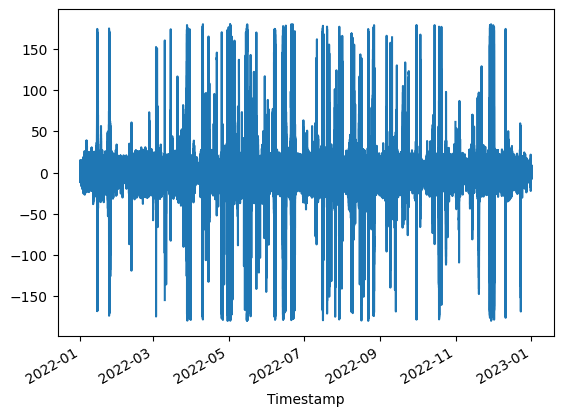

In [72]:
scada["Yaw error"].plot()

In [73]:
scada_clean = scada[(scada["Turbine"]!=target_turbine) 
                    | ((scada["Turbine"]==target_turbine) 
                        & (scada["Blade angle (pitch position) A (°)"]<1.5) 
                        & (scada["Blade angle (pitch position) A (°)"]>-1.5)
                        & (scada["Yaw error"]>-20)
                        & (scada["Yaw error"]<20)
                        )]

# scada_clean = scada.copy()


In [74]:
scada_clean

,Wind speed (m/s),wind_direction_cos,wind_direction_sin,Power (kW),Blade angle (pitch position) A (°),Turbine,Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,6.781222,-0.994889,-0.100976,630.889598,0.0000,Kelmarsh_1,7.936005
2022-01-01 00:10:00,6.936052,-0.986404,-0.164336,809.339449,0.0000,Kelmarsh_1,4.272666
2022-01-01 00:20:00,7.294642,-0.988629,-0.150376,893.607333,0.0470,Kelmarsh_1,5.082625
2022-01-01 00:30:00,8.080467,-0.988157,-0.153444,995.583734,0.0065,Kelmarsh_1,4.904804
2022-01-01 00:40:00,7.021328,-0.980778,-0.195128,926.519441,0.0060,Kelmarsh_1,2.479140
...,...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,-0.864330,-0.502924,1447.101428,0.1090,Kelmarsh_6,-4.735754
2022-12-31 23:20:00,9.149686,-0.879107,-0.476624,1572.766687,0.3910,Kelmarsh_6,-3.007247
2022-12-31 23:30:00,9.571797,-0.833503,-0.552514,1653.457245,1.1805,Kelmarsh_6,-8.081761


In [75]:
scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

C:\Users\Charlie\AppData\Local\Temp\ipykernel_2736\4243526468.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")


In [76]:
scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

In [77]:
scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

In [78]:
scada_others

,Turbine,Wind speed (m/s),wind_direction_cos,wind_direction_sin,Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,Kelmarsh_1,6.781222,-0.994889,-0.100976,630.889598,0.0000,7.936005
2022-01-01 00:00:00,Kelmarsh_2,6.649725,-0.995992,-0.089440,630.786577,0.0000,8.279502
2022-01-01 00:00:00,Kelmarsh_3,6.526749,-0.981500,-0.191464,593.362961,0.0000,0.054329
2022-01-01 00:00:00,Kelmarsh_4,6.736784,-0.996176,-0.087373,613.850131,0.0000,6.363253
2022-01-01 00:00:00,Kelmarsh_6,6.133781,-0.993237,-0.116108,444.272346,0.0000,7.437901
...,...,...,...,...,...,...,...
2022-12-31 23:20:00,Kelmarsh_1,9.730098,-0.900639,-0.434567,1572.972638,0.9735,3.339510
2022-12-31 23:20:00,Kelmarsh_2,9.295921,-0.901414,-0.432958,1642.098862,0.4495,7.510591
2022-12-31 23:20:00,Kelmarsh_3,7.491813,-0.873131,-0.487485,948.692542,0.0090,3.867630


In [79]:
X = scada_others.pivot(columns='Turbine')
y = scada_target

In [80]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [81]:
X["yaw_error"] = scada_target["Yaw error"] # adding yaw error as a feature, so it can be used in determining what yaw error provides optimal power 

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X.copy()
X_test = X.copy()
y_train = y.copy()
y_test = y.copy()

In [83]:
X

,Windspeedms_Kelmarsh_1,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_6,wind_direction_cos_Kelmarsh_1,wind_direction_cos_Kelmarsh_2,wind_direction_cos_Kelmarsh_3,wind_direction_cos_Kelmarsh_4,wind_direction_cos_Kelmarsh_6,...,BladeanglepitchpositionA_Kelmarsh_2,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_6,Yawerror_Kelmarsh_1,Yawerror_Kelmarsh_2,Yawerror_Kelmarsh_3,Yawerror_Kelmarsh_4,Yawerror_Kelmarsh_6,yaw_error
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,6.781222,6.649725,6.526749,6.736784,6.133781,-0.994889,-0.995992,-0.981500,-0.996176,-0.993237,...,0.0000,0.0000,0.0000,0.000,7.936005,8.279502,0.054329,6.363253,7.437901,15.093580
2022-01-01 00:10:00,6.936052,7.172483,7.795904,6.162219,5.848290,-0.986404,-0.976280,-0.979874,-0.986540,-0.988479,...,0.0145,0.1960,0.0000,0.000,4.272666,0.906545,-0.421944,-5.459333,-6.295805,13.313166
2022-01-01 00:20:00,7.294642,7.092553,7.577127,6.058528,5.683789,-0.988629,-0.968040,-0.981631,-0.980613,-0.984083,...,0.0000,0.0000,0.0000,0.000,5.082625,-1.113780,0.093829,2.522211,-7.826455,4.286828
2022-01-01 00:30:00,8.080467,7.185699,7.774836,6.851648,6.080469,-0.988157,-0.971962,-0.974693,-0.961614,-0.969137,...,0.0000,0.0180,0.0000,0.000,4.904804,-0.188826,-1.824809,-0.999015,-11.862085,6.997161
2022-01-01 00:40:00,7.021328,7.110317,7.358590,7.567326,6.682785,-0.980778,-0.956558,-0.949077,-0.953696,-0.951591,...,0.0245,0.0000,0.0155,0.000,2.479140,-3.539474,-7.270820,-2.576542,-10.367238,-2.241580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,8.943925,8.998160,9.182801,8.787624,7.316843,-0.732187,-0.718023,-0.678224,-0.807669,-0.686508,...,0.2790,0.2095,0.1245,0.000,4.825872,-0.522117,1.113954,7.332962,-2.474310,6.601432
2022-12-31 22:50:00,8.366701,8.588931,6.869543,7.945592,7.511415,-0.808731,-0.844547,-0.741831,-0.851596,-0.788441,...,0.0000,0.0000,0.0000,0.000,4.479713,9.570002,6.296594,9.010378,6.156532,-8.622895
2022-12-31 23:00:00,9.200417,9.562916,6.708959,7.662811,7.326496,-0.846370,-0.888515,-0.785716,-0.893659,-0.849881,...,0.7225,0.0000,0.0000,0.000,3.501678,5.451175,7.907457,2.532536,1.370319,1.181715


# AutoML Wind Speed

In [84]:
target_feature = "Wind speed (m/s)"

In [85]:
# Training with AutoGluon
predictor = TabularPredictor(
    label=target_feature, 
    eval_metric='mae',
)
predictor.fit(
    train_data=pd.concat([X_train,y_train[target_feature]],axis=1), 
    time_limit=60*autoML_duration_mins, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto',
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250208_225059"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.76 GB / 15.94 GB (29.9%)
Disk Space Avail:   181.73 GB / 931.51 GB (19.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [86]:
target_prediction = predictor.predict(X_test)

In [87]:
target_prediction.name = "target_prediction"

In [88]:
target_result = pd.concat([X_test,y_test,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.12964451699526816

In [89]:
X_test["yaw_error"] = 0 # set this to zero so that yaw_error does not impact the predicted wind speed

target_prediction = predictor.predict(X_test)

In [90]:
target_prediction.name = "target_prediction"

In [91]:
target_result = pd.concat([X_test,y_test,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.18135145804276864

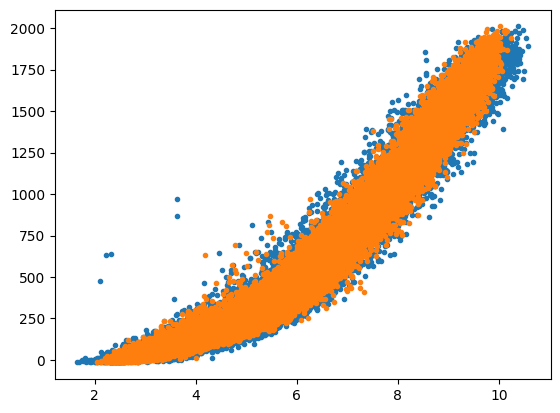

In [92]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction"],target_result["Power (kW)"],marker='.',linestyle='')
plt.show()

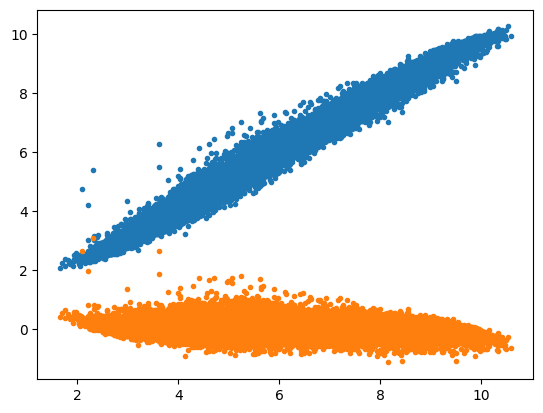

In [93]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction"]-target_result["Wind speed (m/s)"],marker='.',linestyle='')
plt.show()

In [94]:
ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
vane_bins=np.linspace(-25,25,51)

target_result['yaw_bin'] = pd.cut(target_result['Yaw error'], vane_bins)

# target_result_filtered['ws_bin'] = pd.cut(target_result_filtered['Wind speed (m/s)'], ws_bins)
target_result['ws_bin'] = pd.cut(target_result['target_prediction'], ws_bins)

In [95]:
target_result_sye = target_result.groupby(by=["ws_bin","yaw_bin"]).agg(
    Median=("Power (kW)", 'median'),
    Count=("Power (kW)", 'count'),
    Mean=("Power (kW)", 'mean'))

target_result_sye = target_result_sye.reset_index()


C:\Users\Charlie\AppData\Local\Temp\ipykernel_2736\2066444576.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_result_sye = target_result.groupby(by=["ws_bin","yaw_bin"]).agg(


In [96]:
target_result_sye["ws_bin_left"] = pd.IntervalIndex(target_result_sye['ws_bin']).left
target_result_sye["yaw_bin_left"] = pd.IntervalIndex(target_result_sye['yaw_bin']).left

sye_data = target_result_sye.dropna()

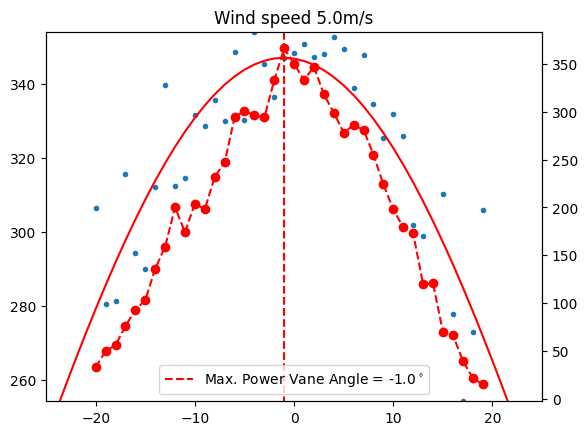

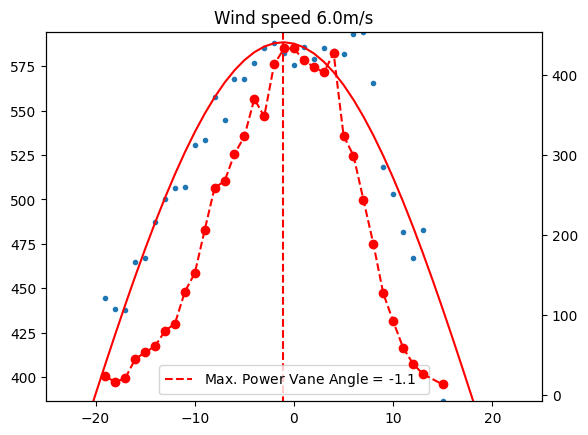

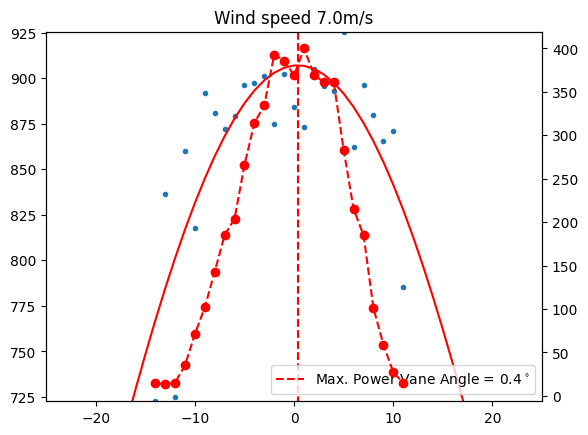

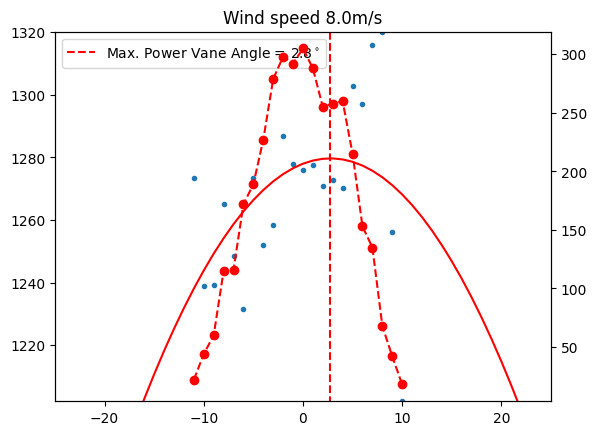

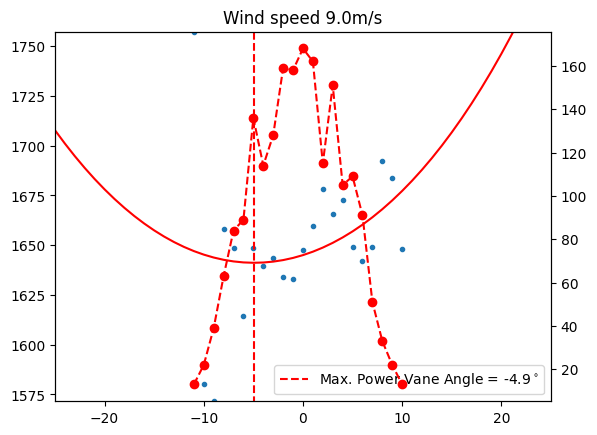

In [97]:
for ws_bin in set(sye_data["ws_bin_left"]):
    sye_ws_bin = sye_data[sye_data["ws_bin_left"]==ws_bin]
    
    sye_ws_bin = sye_ws_bin[sye_ws_bin["Count"]>10] # filter out bins with low counts
    
    fig = plt.figure()
    ax = fig.add_subplot(111)


    ax.plot(sye_ws_bin["yaw_bin_left"],sye_ws_bin["Median"],marker=".",linestyle="")

    curve_fit_params = curve_fit(cos_curve, 
            sye_ws_bin["yaw_bin_left"], 
            sye_ws_bin["Median"], 
            [sye_ws_bin["Median"].max(), 0.0, 2.0],
            maxfev=1000)[0]

    ax.plot(vane_bins,cos_curve(vane_bins,*curve_fit_params),c="red")
    
    ax.plot(
        2*[curve_fit_params[1]],
        [
                sye_ws_bin["Median"].max(),
                sye_ws_bin["Median"].min(),
        ],
        color="red",
        linestyle="--",
        label=rf"Max. Power Vane Angle = {round(curve_fit_params[1],1)}$^\circ$",  # noqa: W605
        )
    
    ax2 = ax.twinx()
    ax2.plot(sye_ws_bin["yaw_bin_left"], sye_ws_bin["Count"], marker="o", linestyle="--", color="red", label="Count")

    plt.title(f"Wind speed {ws_bin}m/s")
    
    ax.legend()
    ax.set_xlim([-25,25])
    ax.set_ylim([sye_ws_bin["Median"].min(),sye_ws_bin["Median"].max()])

# AutoML Power

In [98]:
target_feature = "Power (kW)"

In [99]:
# Training with AutoGluon
predictor = TabularPredictor(
    label=target_feature, 
    eval_metric='mae'
)
predictor.fit(
    train_data=pd.concat([X_train,y_train[target_feature]],axis=1), 
    time_limit=60*autoML_duration_mins, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto',
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250208_225800"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.89 GB / 15.94 GB (30.7%)
Disk Space Avail:   180.78 GB / 931.51 GB (19.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

In [100]:
target_prediction = predictor.predict(X_test)

In [101]:
target_prediction.name = "target_prediction"

In [102]:
target_result = pd.concat([X_test,y_test,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

26.228808066879495

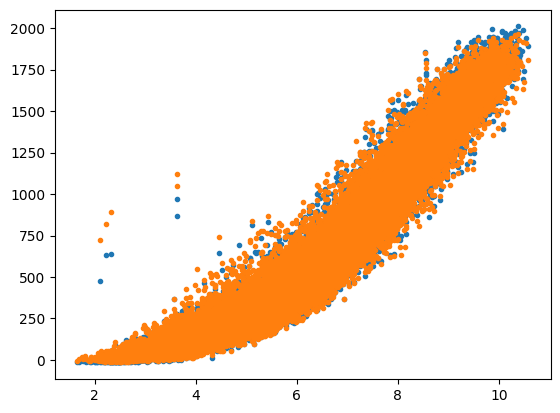

In [103]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction"],marker='.',linestyle='')
plt.show()

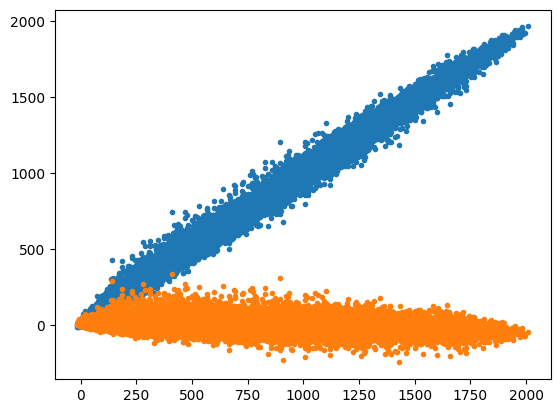

In [104]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
# plt.ylim([-5,20])
plt.show()

In [105]:
X_tmp = X_test.copy()
X_tmp["yaw_error"] = 0
target_prediction = predictor.predict(X_tmp)

In [106]:
power_level = pd.DataFrame(target_prediction)

In [107]:
power_bins = range(0,2250,250)
power_bin = pd.cut(target_prediction,power_bins)
power_level = list(pd.IntervalIndex(power_bin).mid)

In [108]:
X_tmp = X_test.copy()

yaw_angles = range(-10, 11)
power_outputs = []

for yaw_angle in yaw_angles:
    print(yaw_angle)
    X_tmp = X_test.copy()
    X_tmp["yaw_error"] = yaw_angle
    target_prediction = predictor.predict(X_tmp)
    target_prediction = pd.DataFrame(target_prediction)
    target_prediction["power_level"]=power_level
    power_outputs.append(target_prediction.groupby(by=["power_level"])["Power (kW)"].mean())
    


In [109]:
results = pd.concat(power_outputs,axis=1).T

In [110]:
results = (results/results.mean())

In [111]:
results.index = yaw_angles

Text(0.5, 1.0, 'Kelmarsh_5')

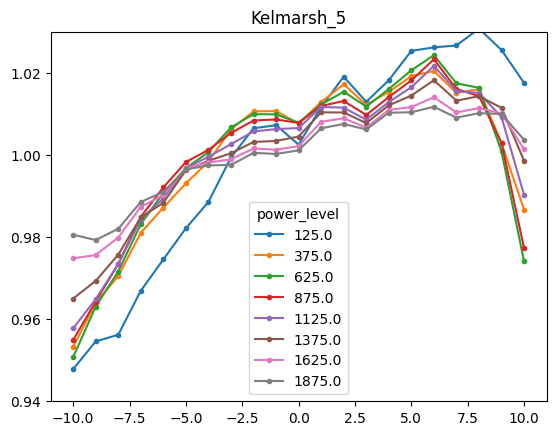

In [112]:
ax = results.plot(marker=".")
ax.set_ylim([0.94,1.03])
ax.set_title(target_turbine)

# Change in performance over time?

Compare expect power to actual

In [113]:
target_prediction = predictor.predict(X_test)

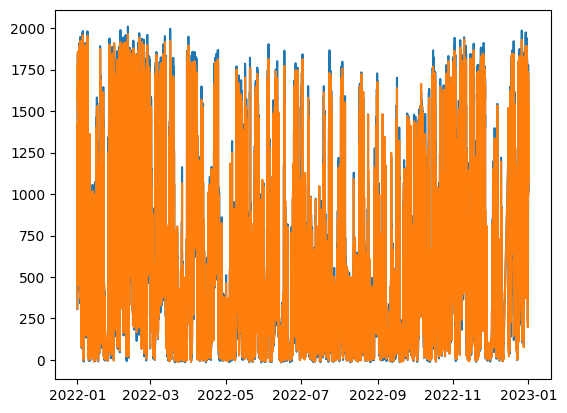

In [118]:
plt.figure()
plt.plot(target_result[target_feature])
plt.plot(target_result["target_prediction"])
# plt.ylim([-5,20])
plt.show()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_2736\3252793462.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  (target_result[target_feature]-target_result["target_prediction"]).resample("1H").mean()


Timestamp
2022-01-01 00:00:00   -57.010899
2022-01-01 01:00:00   -21.416130
2022-01-01 02:00:00   -25.520702
2022-01-01 03:00:00   -71.299877
2022-01-01 04:00:00   -60.027461
                         ...    
2022-12-31 19:00:00    24.021047
2022-12-31 20:00:00    -9.344577
2022-12-31 21:00:00    16.853912
2022-12-31 22:00:00   -21.134364
2022-12-31 23:00:00    31.324035
Freq: h, Length: 8760, dtype: float64

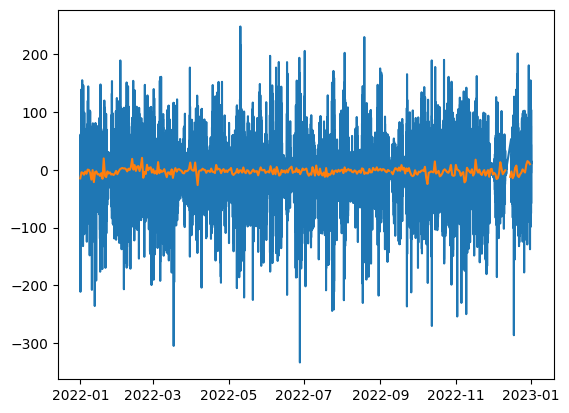

In [127]:
plt.figure()
plt.plot(target_result[target_feature]-target_result["target_prediction"])
plt.plot((target_result[target_feature]-target_result["target_prediction"]).resample("1D").median())
# plt.ylim([-5,20])
plt.show()